# Elo Merchant Category Recommendation - LynxKite feature boosting and LightGBM with StratifiedKFold
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

Inspired by [Feature engineering](https://github.com/zzsza/Play-Kaggle/blob/master/Elo-Merchant-Category-Recommendation/notebooks/03.Feature-Engineering.ipynb)

In [104]:
import os
import gc
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

random.seed(1)

sns.set(rc={'figure.figsize':(15, 8)})
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Feature engineering
Inspired by [Feature Engineering](https://github.com/zzsza/Play-Kaggle/blob/master/Elo-Merchant-Category-Recommendation/notebooks/04.Feature-Engineering_2nd.ipynb)

### Train & test data

In [21]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"])
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
201,917 observations and 6 features in train set.


In [22]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"])
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
123,623 observations and 5 features in test set.


In [23]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
df_train['elapsed_days'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days

In [24]:
df_test['first_active_month'] = pd.to_datetime(df_test['first_active_month'])
df_test['elapsed_days'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days

### Transactions

In [7]:
%%time
df_hist_trans = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Number of historical transactions: 29,112,361
Wall time: 7min 8s


In [8]:
%%time
df_new_trans = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)
Number of new transactions: 1,963,031
Wall time: 7.34 s


In [9]:
df_new_trans.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

Missing data handling (why these values?)

In [10]:
for df in [df_hist_trans, df_new_trans]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

Date handling

In [11]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_weekend'] = (df[source_column].dt.weekday >=5).astype(int)
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

In [12]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [13]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [14]:
df_hist_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_hist_trans['purchase_date'].dt.date).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']

In [15]:
df_new_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_new_trans['purchase_date'].dt.date).dt.days)//30
df_new_trans['month_diff'] += df_new_trans['month_lag']

In [16]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 3637.05 MB
Reduced memory usage: 1638.06 MB (55.0% reduction)


In [17]:
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 241.50 MB
Reduced memory usage: 106.71 MB (55.8% reduction)


#### Aggregation

In [18]:
def aggregate_transactions(df, prefix):
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],

        'card_id': ['size'],
        'category_1': ['sum', 'mean'],
        
        'installments': ['sum', 'max', 'min', 'mean', 'var'],

        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_diff': ['mean'],
        'month_lag': ['max','min','mean','var'],

        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_date': ['max', 'min'],
        'purchase_dayofweek': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_year': ['nunique'],
        'purchase_weekend': ['sum', 'mean'],
        'purchase_weekofyear': ['nunique'],

        'subsector_id': ['nunique']
    }

    df['category_2_mean'] = df.groupby(['category_2'])['purchase_amount'].transform('mean')
    df['category_3_mean'] = df.groupby(['category_3'])['purchase_amount'].transform('mean')

    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_' + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(drop=False, inplace=True)
    df_agg[prefix + '_purchase_date_diff'] = (df_agg[prefix + '_purchase_date_max'] - df_agg[prefix + '_purchase_date_min']).dt.days
    df_agg[prefix + '_purchase_date_average'] = df_agg[prefix + '_purchase_date_diff']/df_agg[prefix + '_card_id_size']
    df_agg[prefix + '_purchase_date_uptonow'] = (datetime.datetime.today() - df_agg[prefix + '_purchase_date_max']).dt.days

    df = (df_agg.groupby('card_id').size().reset_index(name='{}_transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')
    return df_agg

In [25]:
df_hist_agg = aggregate_transactions(df_hist_trans, 'hist')
df_new_agg = aggregate_transactions(df_new_trans, 'new')

df_train = df_train.merge(df_hist_agg, on='card_id', how='left')
df_train = df_train.merge(df_new_agg, on='card_id', how='left')

df_test = df_test.merge(df_hist_agg, on='card_id', how='left')
df_test = df_test.merge(df_new_agg, on='card_id', how='left')

In [26]:
df_hist_agg[:3]

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_card_id_size,hist_category_1_sum,hist_category_1_mean,hist_installments_sum,hist_installments_max,hist_installments_min,...,hist_purchase_hour_nunique,hist_purchase_month_nunique,hist_purchase_year_nunique,hist_purchase_weekend_sum,hist_purchase_weekend_mean,hist_purchase_weekofyear_nunique,hist_subsector_id_nunique,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow
0,C_ID_00007093c1,1,114.0,0.765101,149,28.0,0.187919,192,6,1,...,18,12,2,25.0,0.167785,39,13,377,2.530201,359
1,C_ID_0001238066,1,120.0,0.975610,123,2.0,0.016260,198,10,-1,...,20,6,2,52.0,0.422764,23,17,151,1.227642,358
2,C_ID_0001506ef0,1,62.0,0.939394,66,0.0,0.000000,1,1,0,...,15,11,2,32.0,0.484848,24,12,398,6.030303,368


In [27]:
del df_hist_trans, df_new_trans, df_hist_agg, df_new_agg
gc.collect()

273

In [28]:
df_train['hist_first_buy'] = (df_train['hist_purchase_date_min'] - df_train['first_active_month']).dt.days
df_train['new_first_buy'] = (df_train['new_purchase_date_min'] - df_train['first_active_month']).dt.days

df_test['hist_first_buy'] = (df_test['hist_purchase_date_min'] - df_test['first_active_month']).dt.days
df_test['new_first_buy'] = (df_test['new_purchase_date_min'] - df_test['first_active_month']).dt.days

In [29]:
for f in ['hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']:
    df_train[f] = df_train[f].astype(np.int64) * 1e-9
    df_test[f] = df_test[f].astype(np.int64) * 1e-9

df_train['card_id_total'] = df_train['hist_card_id_size'] + df_train['new_card_id_size']
df_test['card_id_total'] = df_test['hist_card_id_size'] + df_test['new_card_id_size']

df_train['purchase_amount_total'] = df_train['hist_purchase_amount_sum'] + df_train['new_purchase_amount_sum']
df_test['purchase_amount_total'] = df_test['hist_purchase_amount_sum'] + df_test['new_purchase_amount_sum']

In [30]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [31]:
for f in ['feature_1', 'feature_2', 'feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

### Loading features from LynxKite
#### Modular clustering

In [55]:
df_lk_mc = pd.read_csv("LynxKite_export/LynxKite-modular_clusters_id_first.csv")
df_lk_mc = reduce_mem_usage(df_lk_mc)
print("{:,} observations and {} features in train set.".format(df_lk_mc.shape[0], df_lk_mc.shape[1]))

Starting memory usage:  7.45 MB
Reduced memory usage:  6.21 MB (16.7% reduction)
325,540 observations and 3 features in train set.


In [56]:
le = preprocessing.LabelEncoder()
le.fit(df_lk_mc['modular_clusters_id_first'])
df_lk_mc['modular_clusters_id_first'] = le.transform(df_lk_mc['modular_clusters_id_first'])

le.fit(df_lk_mc['modular_clusters_size_first'])
df_lk_mc['modular_clusters_size_first'] = le.transform(df_lk_mc['modular_clusters_size_first'])

In [57]:
print('Number of unique records of \nmodular_clusters_id_first - {:,}\nmodular_clusters_size_first - {:,}'.format(
    df_lk_mc['modular_clusters_id_first'].max(),
    df_lk_mc['modular_clusters_size_first'].max(),
))

Number of unique records of 
modular_clusters_id_first - 39,246
modular_clusters_size_first - 26


In [58]:
df_lk_mc[:3]

,card_id,modular_clusters_id_first,modular_clusters_size_first
0,C_ID_7d9dee148a,4926,14
1,C_ID_a7d06696b1,14326,25
2,C_ID_b9aeb45f7b,22988,19


#### Target top/bottom, wavg purchase amount/date

In [34]:
df_lk_tt = pd.read_csv("LynxKite_export/LynxKite-target_top-target_wavg_purchase_amount-wavg_purchase_date.csv")
df_lk_tt = reduce_mem_usage(df_lk_tt)
print("{:,} observations and {} features in train set.".format(df_lk_tt.shape[0], df_lk_tt.shape[1]))

Starting memory usage: 52.16 MB
Reduced memory usage: 21.11 MB (59.5% reduction)
325,540 observations and 21 features in train set.


In [35]:
df_lk_tt[:3]

,card_id,neighborhood_target_top_avg_average,neighborhood_target_top_avg_first,neighborhood_target_top_avg_max,neighborhood_target_top_avg_min,neighborhood_target_top_avg_most_common,neighborhood_target_bottom_avg_average,neighborhood_target_bottom_avg_first,neighborhood_target_bottom_avg_max,neighborhood_target_bottom_avg_min,...,neighborhood_target_wavg_purchase_amount_average,neighborhood_target_wavg_purchase_amount_first,neighborhood_target_wavg_purchase_amount_max,neighborhood_target_wavg_purchase_amount_min,neighborhood_target_wavg_purchase_amount_most_common,neighborhood_target_wavg_purchase_date_average,neighborhood_target_wavg_purchase_date_first,neighborhood_target_wavg_purchase_date_max,neighborhood_target_wavg_purchase_date_min,neighborhood_target_wavg_purchase_date_most_common
0,C_ID_f26081eca3,0.275635,0.098267,0.475342,0.000000,0.214600,6.066406,12.468750,35.125000,0.270508,...,297.294617,62.974602,1039.092651,13.289358,135.277939,25528.681641,2833.434326,248088.328125,2.705562,137.098816
1,C_ID_0ba76b9ea2,0.107361,0.218750,0.218750,0.016052,0.016052,6.550781,1.922852,8.867188,1.922852,...,92.109688,28.921249,137.276337,28.921249,137.276337,12431.413086,1031.070190,27440.634766,1031.070190,27440.634766
2,C_ID_44946612a5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merging

In [59]:
df_train = df_train.merge(df_lk_mc, on='card_id', how='left')
df_test = df_test.merge(df_lk_mc, on='card_id', how='left')

In [60]:
df_train = df_train.merge(df_lk_tt, on='card_id', how='left')
df_test = df_test.merge(df_lk_tt, on='card_id', how='left')

### Training
[LightGBM parameter tuning](https://testlightgbm.readthedocs.io/en/latest/Parameters-tuning.html)<br/>
[What is LightGBM, How to implement it? How to fine tune the parameters?](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

In [61]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers']]
target = df_train['target']
del df_train['target']

In [106]:
%%time
param = {
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 1,
    "boosting": "rf",

    "early_stopping_round": 100,
    "feature_fraction": 0.9,
    "feature_fraction_seed": 1,

    "lambda_l1": 0.01,
    #"lambda_l2": 0.001,
    "learning_rate": 0.01,

    "max_bin": 7,
    'max_depth': 5,
    "metric": "rmse",
    "min_data_in_leaf": 5,
    #"min_gain_to_split": 0.2,
    #"min_sum_hessian_in_leaf": 1e-3,
    #"min_child_samples": 20,
    #"num_iterations": 100,
    #"num_boost_round": 100,
    "num_leaves": 15,

    "objective": "regression",

    "random_state": 1,
    "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
evals_result = {}
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['outliers'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], evals_result=evals_result, verbose_eval=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.4169	valid_1's rmse: 3.42596
Early stopping, best iteration is:
[33]	training's rmse: 3.41614	valid_1's rmse: 3.42614

Fold 2.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.42967	valid_1's rmse: 3.37447
Early stopping, best iteration is:
[33]	training's rmse: 3.42909	valid_1's rmse: 3.37409

Fold 3.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.41799	valid_1's rmse: 3.42175
[200]	training's rmse: 3.41796	valid_1's rmse: 3.42173
Early stopping, best iteration is:
[134]	training's rmse: 3.41737	valid_1's rmse: 3.42124

Fold 4.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.40885	valid_1's rmse: 3.46601
Early stopping, best iteration is:
[33]	training's rmse: 3.40763	valid_1's rmse: 3.46392

Fold 5.
Training until validation scores don't improve for 100 rounds.
[100]	tra

In [107]:
cv_score = np.sqrt(mean_squared_error(oof, target))
print("CV score: {:.6f}".format(cv_score))

CV score: 3.421593


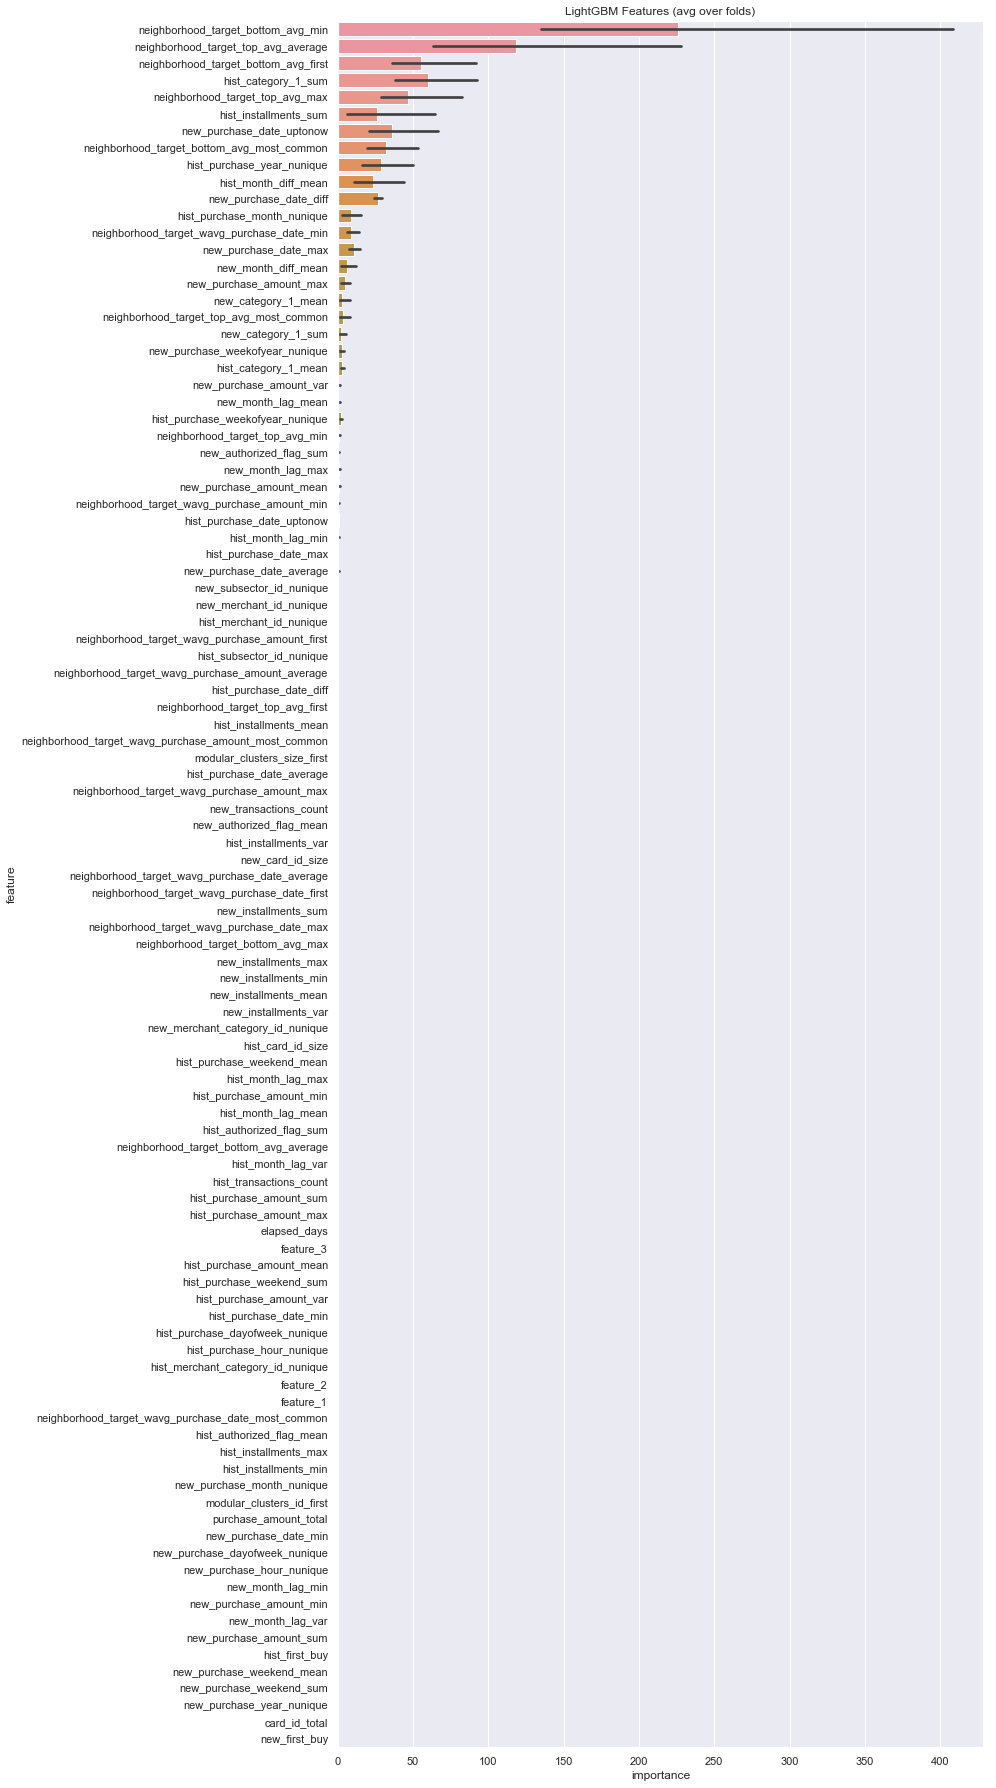

In [108]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [109]:
best_features[best_features['importance'] > 0]['feature'].unique()

array(['hist_category_1_sum', 'hist_category_1_mean',
       'hist_installments_sum', 'hist_month_diff_mean',
       'hist_purchase_month_nunique', 'hist_purchase_year_nunique',
       'hist_purchase_weekofyear_nunique', 'hist_purchase_date_uptonow',
       'new_month_diff_mean', 'new_purchase_amount_max',
       'new_purchase_date_max', 'new_purchase_weekofyear_nunique',
       'new_purchase_date_diff', 'new_purchase_date_average',
       'new_purchase_date_uptonow', 'neighborhood_target_top_avg_average',
       'neighborhood_target_top_avg_max',
       'neighborhood_target_top_avg_min',
       'neighborhood_target_top_avg_most_common',
       'neighborhood_target_bottom_avg_first',
       'neighborhood_target_bottom_avg_min',
       'neighborhood_target_bottom_avg_most_common',
       'neighborhood_target_wavg_purchase_amount_min',
       'neighborhood_target_wavg_purchase_date_min', 'new_month_lag_max',
       'new_purchase_amount_mean', 'hist_month_lag_min',
       'hist_purchase_d

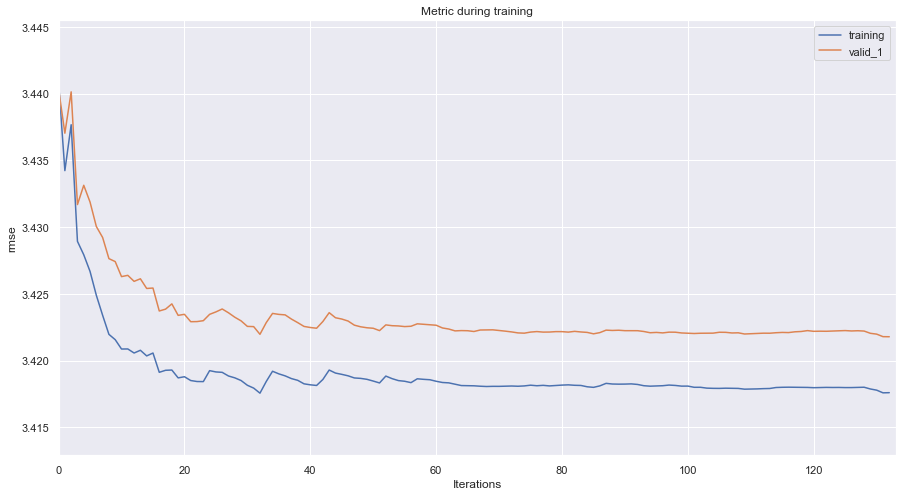

In [110]:
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

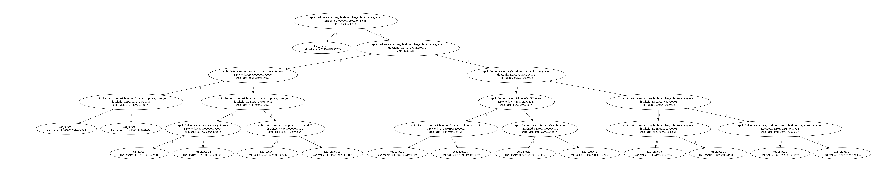

In [111]:
ax = lgb.plot_tree(clf, tree_index=1, figsize=(15, 20), show_info=['split_gain'])
plt.show()

In [112]:
graph = lgb.create_tree_digraph(clf, tree_index=1, name='LightGBM_boosted_with_LynxKite_features')
graph.render(view=True)

'LightGBM_boosted_with_LynxKite_features.gv.pdf'

In [114]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions
sub_df.to_csv("output/regression_with_lk_{:.6f}.csv".format(cv_score), index=False)
print("regression_with_lk_{:.6f}.csv is saved".format(cv_score))

regression_with_lk_3.421593.csv is saved


[Just Train Data - LGB & XGB & CatBoost w/ Blending](https://www.kaggle.com/silverstone1903/just-train-data-lgb-xgb-catboost-w-blending/data)<br/>
[MultiModel + RIDGE + STACKING](https://www.kaggle.com/ashishpatel26/rmse-3-66-multimodel-ridge-stacking)
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/75935